In [2]:
import os
import time

import matplotlib.pyplot as plt
import timm_3d
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm
import logging
import seaborn as sn

from rsna_dataloader import *
from train_3d_model import *
from constants import *

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)


In [21]:
import torch

model = CustomMaxxVit3dClassifier(backbone=CONFIG["backbone"]).to(device)
model.load_state_dict(torch.load("../models/maxvit_rmlp_bc_rw_96_v2_fold_3/maxvit_rmlp_bc_rw_96_v2_fold_3_10.pt"))
_ = model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [22]:
bounds_dataframe = pd.read_csv(os.path.join("../data/SpineNet/bounding_boxes_3d.csv"))

In [23]:
coords_dataframe = pd.read_csv(os.path.join("../data/SpineNet/coords_3d.csv"))

In [24]:
import numpy as np

conditions = sorted(TRAINING_DATA["condition"].unique())

transform_3d_val = tio.Compose([
    tio.RescaleIntensity((0, 1)),
])

train_data = TRAINING_DATA[TRAINING_DATA["study_id"].isin(bounds_dataframe["study_id"])]
folds = create_vertebra_level_datasets_and_loaders_k_fold(train_data,
                                                          bounds_dataframe,
                                                          coords_df=coords_dataframe,
                                                            transform_3d_train=transform_3d_val,
                                                            transform_3d_val=transform_3d_val,
                                                            base_path=os.path.join(
                                                                DATA_BASEPATH,
                                                                "train_images"),
                                                            vol_size=(96, 96, 96),
                                                            num_workers=0,
                                                            split_k=5,
                                                            batch_size=1,
                                                            use_mirroring_trick=True)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [25]:
trainloader, valloader, trainset, valset = folds[3]

In [26]:
from torch.cuda.amp import autocast
from tqdm import tqdm

inferred = []
target = []

inferred_per_level = {i:[] for i in range(5)}
target_per_level = {i: [] for i in range(5)}

with torch.no_grad():
    with autocast(dtype=torch.bfloat16):
        for image, level, label in tqdm(valloader):
            out = model(image.to(device), level.to(device)).cpu().detach()
            
            target.append(label.detach())
            inferred.append(out)

            level_idx = np.argmax(level.numpy())
            inferred_per_level[level_idx].append(out)
            target_per_level[level_idx].append(label.detach())

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
100%|███████████████████████████████████████████████████████████████████████████████| 1745/1745 [06:51<00:00,  4.24it/s]


In [27]:
inferred_new = []
target_new = []
for e in inferred:
    for elem in e:
        inferred_new.append(F.softmax(elem.reshape((-1, 5, 3)), dim=-1).to(torch.float))
for e in target:
    for elem in e:
        target_new.append([[0 if i != elem_ else 1 for i in range(3)] for elem_ in elem])
        
        
inferred_new[1], target_new[1]

(tensor([[[8.8672e-01, 1.1377e-01, 7.1335e-04],
          [6.9922e-01, 2.8906e-01, 1.0559e-02],
          [9.2578e-01, 7.5195e-02, 1.0300e-03],
          [7.5391e-01, 2.3438e-01, 1.2207e-02],
          [9.7656e-01, 2.3560e-02, 1.8406e-04]]]),
 [[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]])

In [28]:
inferred_l = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in inferred_new]
target_l = [[np.argmax(e_) for e_ in e] for e in target_new]

In [29]:
len(inferred_l[1]), len(target_l[1])

(5, 5)

In [30]:
conditions

['Left Neural Foraminal Narrowing',
 'Left Subarticular Stenosis',
 'Right Neural Foraminal Narrowing',
 'Right Subarticular Stenosis',
 'Spinal Canal Stenosis']

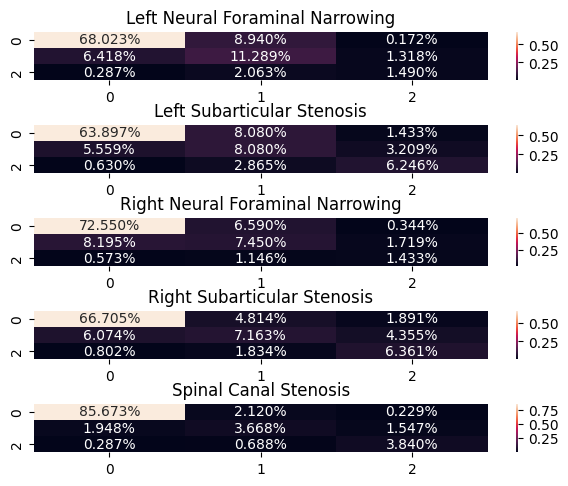

In [31]:
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
from operator import truediv

precisions = []
recalls = []

fig, ax = plt.subplots(nrows=5, ncols=1, squeeze=False)
fig.tight_layout()
for i in range(5):
    target_ = [e[i] for e in target_l]
    inferred_ = [e[i] for e in inferred_l]
    
    ax[i][0].set_title(conditions[i])
    
    cf_matrix = confusion_matrix(target_, inferred_)
    sn.heatmap(cf_matrix / (np.sum(cf_matrix) + 1e-7), ax=ax[i][0], annot=True, fmt='.3%')

    true_pos = np.diag(cf_matrix)
    prec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=0) + 1e-7))
    rec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=1) + 1e-7))
    
    precisions.append(prec)
    recalls.append(rec)

plt.show()


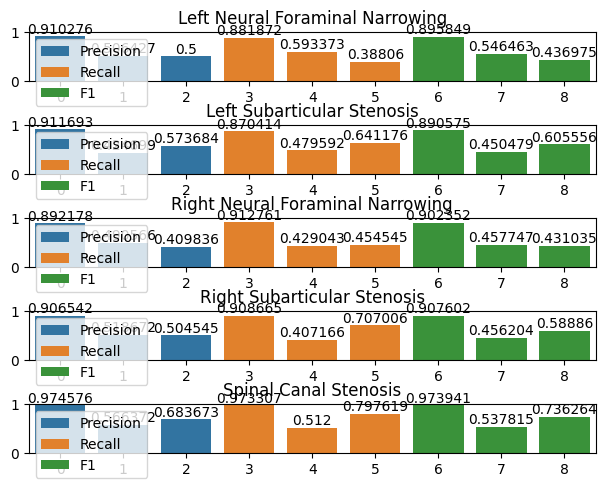

In [32]:
fig, ax = plt.subplots(nrows=5, ncols=1)
fig.tight_layout()

plt.set_loglevel('WARNING')
for i in range(5):
    try:
        val_len = len(precisions[i])
        ax[i].set(ylim=(0, 1))
        
        ax[i].set_title(conditions[i])
        sn.barplot(x=range(val_len), y=precisions[i], ax=ax[i], label='Precision')
        sn.barplot(x=range(val_len, val_len * 2), y=recalls[i], ax=ax[i], label='Recall')
        bar_ax = sn.barplot(x=range(val_len * 2, val_len * 3), y=2 / (1 / (np.array(recalls[i]) + 1e-7) + 1 / (np.array(precisions[i]) + 1e-7)), ax=ax[i], label="F1")
        for i in bar_ax.containers:
           bar_ax.bar_label(i,)
    except:
        pass

plt.show()

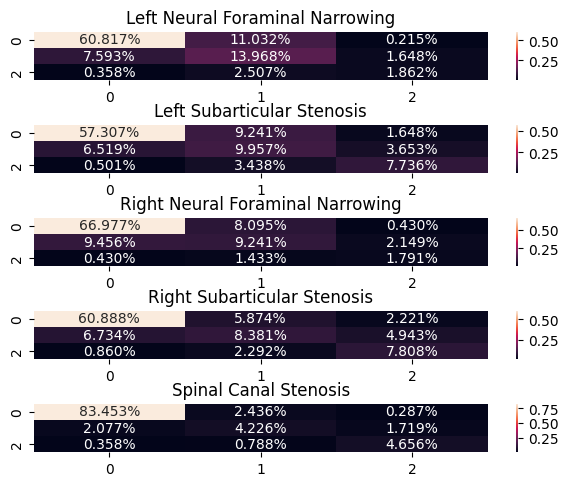

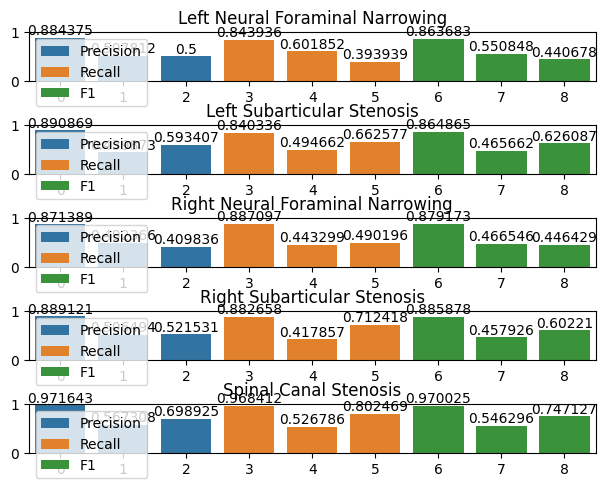

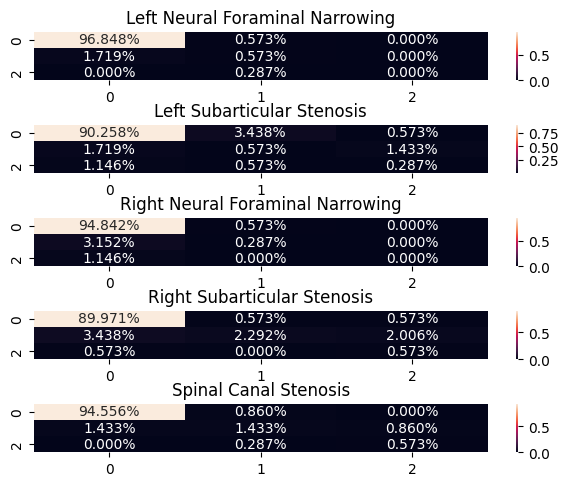

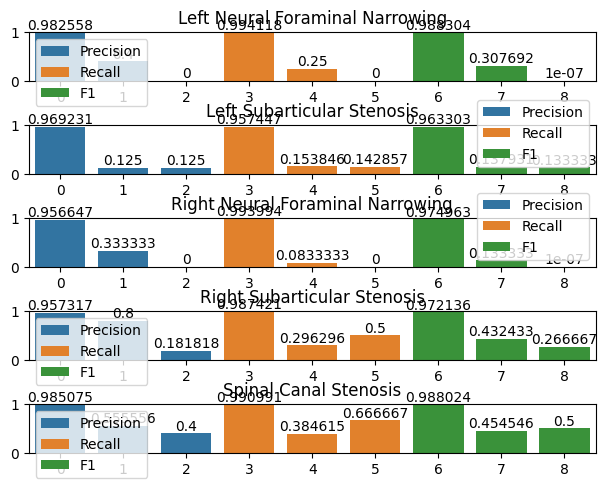

ValueError: zero-size array to reduction operation fmin which has no identity

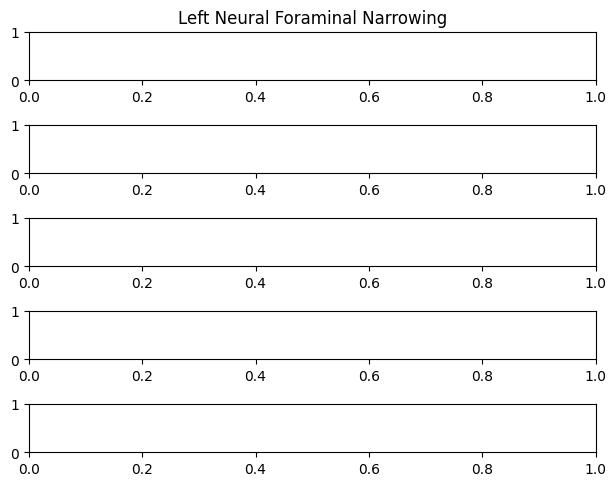

In [33]:
for level_idx in range(5):
    inferred_level = []
    target_level = []
    
    for e in inferred_per_level[level_idx]:
        for elem in e:
            inferred_level.append(F.softmax(elem.reshape((-1, 5, 3)), dim=-1).to(torch.float))
    for e in target_per_level[level_idx]:
        for elem in e:
            target_level.append([[0 if i != elem_ else 1 for i in range(3)] for elem_ in elem])

    inferred_lv = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in inferred_level]
    target_lv = [[np.argmax(e_) for e_ in e] for e in target_level]
    
    precisions = []
    recalls = []

    try:
        fig, ax = plt.subplots(nrows=5, ncols=1, squeeze=False)
        fig.tight_layout()
        for i in range(5):
            target_ = [e[i] for e in target_lv]
            inferred_ = [e[i] for e in inferred_lv]
            
            ax[i][0].set_title(conditions[i])
            
            cf_matrix = confusion_matrix(target_, inferred_)
            sn.heatmap(cf_matrix / (np.sum(cf_matrix) + 1e-7), ax=ax[i][0], annot=True, fmt='.3%')
        
            true_pos = np.diag(cf_matrix)
            prec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=0) + 1e-7))
            rec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=1) + 1e-7))
            
            precisions.append(prec)
            recalls.append(rec)
        
        plt.show()
    except:
        pass

    try:
        fig, ax = plt.subplots(nrows=5, ncols=1)
        fig.tight_layout()
        
        plt.set_loglevel('WARNING')
        for i in range(5):
            try:
                val_len = len(precisions[i])
                ax[i].set(ylim=(0, 1))
                
                ax[i].set_title(conditions[i])
                sn.barplot(x=range(val_len), y=precisions[i], ax=ax[i], label='Precision')
                sn.barplot(x=range(val_len, val_len * 2), y=recalls[i], ax=ax[i], label='Recall')
                bar_ax = sn.barplot(x=range(val_len * 2, val_len * 3), y=2 / (1 / (np.array(recalls[i]) + 1e-7) + 1 / (np.array(precisions[i]) + 1e-7)), ax=ax[i], label="F1")
                for i in bar_ax.containers:
                   bar_ax.bar_label(i,)
            except:
                pass
    except:
        pass
        
    plt.show()